### Importing the basic libraries that are used to perform analysis on python

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

### Reading the data

In [41]:
gold_price_full = pd.read_csv('gold_price_data.csv')
gold_price_full['Date'] = pd.to_datetime(gold_price_full['Date'])

### Lets look at the first few rows of the data

In [42]:
gold_price_full.head()

,Date,Value
0,1992-01-01,353.15
1,1992-02-01,356.40
2,1992-03-01,350.45
3,1992-04-01,344.00
4,1992-05-01,337.50


## `Set the DATE column as the index.`


In [43]:
gold_price_full= gold_price_full.set_index('Date')

In [44]:
gold_price_full.head()

,Value
Date,
1992-01-01,353.15
1992-02-01,356.40
1992-03-01,350.45
1992-04-01,344.00
1992-05-01,337.50


### We will be using data till 2017 to train and forecasting model and will be using the model to forecast the sales for 2018 onwards.

In [45]:
train = gold_price_full.loc[:'2018-01-01',:]
test = gold_price_full.loc['2017-12-01':,:]


In [46]:
train.head()

,Value
Date,
1992-01-01,353.15
1992-02-01,356.40
1992-03-01,350.45
1992-04-01,344.00
1992-05-01,337.50


## Making the time plot of the train dataset to visualise it


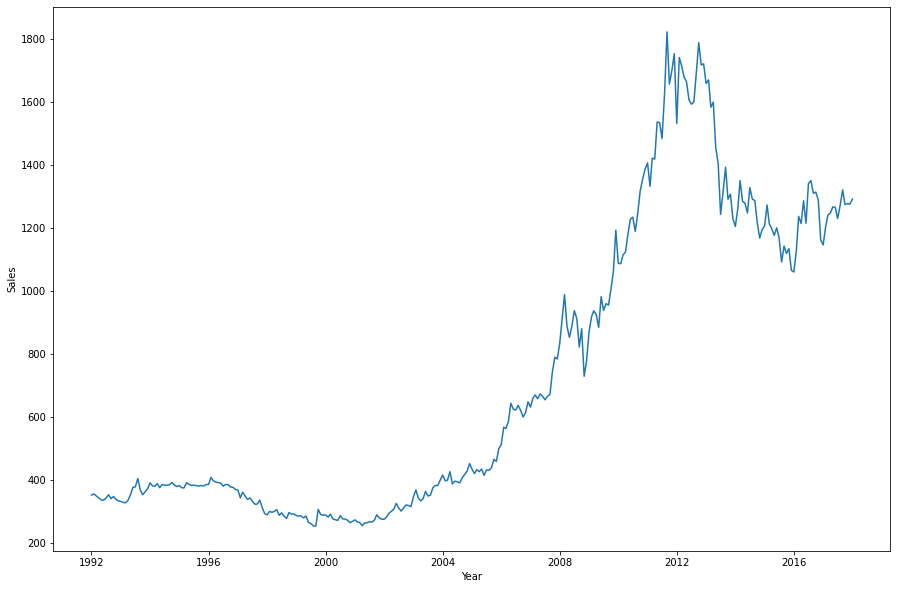

In [47]:
plt.figure(figsize=[15,10])
plt.xlabel('Year')
plt.ylabel('Sales')
plt.plot(train)

## Question - 1: Write your observations about value of gold in detail.

The gold prices seems to be somewhat linear till the year 2006-2007. 
During this period the graph shows first sharp rise in gold price and this trend continues till the year 2011. 
The value of gold is the highest in the year 2011 as per the visual analysis of the gold graph. 
After 2012, we see drop in the gold prices to a certain extent and then the seasonal rise and fall comes into the picture.
The rise in gold prices may have been caused by the great recession that occured from 2007 to 2009 globally.

In [48]:
# Run this cell and don't make any changes
for_sma = train.copy()

First, Let's use a simple forecasting technique. Implementing the simple moving average forecasting model with a rolling window of 12 months

In [49]:
for_sma['SMA_12'] = for_sma['Value'].rolling(window = 12).mean()
for_sma.tail(1)

,Value,SMA_12
Date,,
2018-01-01,1291.0,1263.370833


## Question - 2: According to the results obtained in the previous question, what can you infer about the results obtained? Is the moving average model working fine? 

Since the moving average does not deviate from the actual values by considerably large difference and it also captures the market rise and fall for gold prices, so the moving average model is working fine.

Now lets build an Auto-Regressive models

## Question-3: Before we moving ahead building an Auto Regressive model, we would be required to remove trend and seasonality from the give time series. Answer, why does Trend and seasonality affect Auto regressive models adversely and why is it required to be removed before building a ARIMA model?


Time series datasets may contain trends and seasonality, which may need to be removed prior to modeling. Trends can result in a varying mean over time, whereas 
seasonality can result in a changing variance over time, both which define a time series as being non-stationary.
Because of the stationary assumption. You may model your data without removing those trend trajectory, your data will be non-stationary.
Your parameter estimations are still valid but when it comes to prediction, they fail because of stationary assumption.
Since your goal is to forecast in linear time series. having stationary data (do differencing) would make your prediction falls within your prediction interval, which is normal distribution.

## Lets check the rolling statistics 

In [50]:
train = train.iloc[:-1,:]
from matplotlib.pylab import rcParams
def rolling_means(time_series):
    rolmean  =  time_series.rolling(window = 12).mean()   
    rolstd  =  time_series.rolling(window = 12).std()

    #Plot rolling statistics

    rcParams['figure.figsize']  =  10, 5 

    orig  =  plt.plot(time_series, color = 'blue', label = 'Original')
    mean  =  plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
    std  =  plt.plot(rolstd, color = 'black', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block = False)

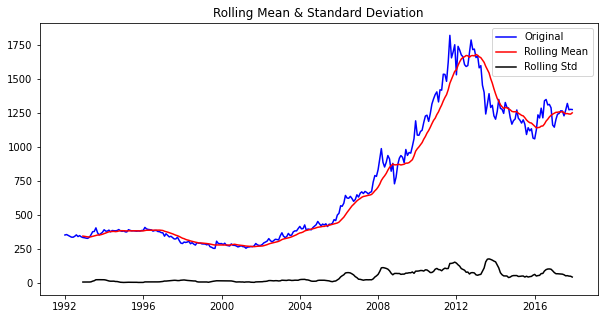

In [51]:
rolling_means(train)

## Question-4: Explain the significance of above step. What can we infre from the above results?

A rolling analysis of a time series model is often used to assess the model’s stability over time.
Using the above technique we are trying to assess the constancy of the model’s parameters by computing parameter estimates over a rolling window of a fixed size, here window size is 12, through the sample. If the parameters are truly constant over the entire sample, then the estimates over the rolling windows should not be too different. If the parameters change at some point during the sample, then the rolling estimates should capture this instability.

From the graph we can infer that the gold prices were stable from 1992 to 2006 as there is not much change in the estimates in this period. From 2007 onwards we can see considerable change and the same can be confirmed by observing the standard deviation. Standard deviation campures the deviation from the mean.


## Perform ADF test to check the stationarity of the data

In [52]:

def adf_test(time_series):
    from statsmodels.tsa.stattools import adfuller
    dftest  =  adfuller(time_series['Value'], autolag = 'AIC')

    dfoutput  =  round(pd.Series(dftest[0:4], index = ['Test Statistic','p-value','#Lags Used','Number of Observations Used']),4)
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key]  =  value
    
    print('Results of Dickey Fuller Test:')    
    print(dfoutput)

In [53]:
adf_test(train)

Results of Dickey Fuller Test:
Test Statistic                  -0.627000
p-value                          0.864800
#Lags Used                      11.000000
Number of Observations Used    300.000000
Critical Value (1%)             -3.452337
Critical Value (5%)             -2.871223
Critical Value (10%)            -2.571929
dtype: float64


## Question-5: What is the null hypothesis of the ADF test? What can you infer from the results of this test?

The Augmented Dickey Fuller Test (ADF) is unit root test for stationarity. Unit roots can cause unpredictable results in your time series analysis.
The null hypothesis for this test is that there is a unit root.

The inference from the result of ADF test is stated below:-
The p-value is obtained is greater than significance level of 0.05 and the ADF statistic is higher than any of the critical values. Clearly, there is no reason to reject the null hypothesis. So, the time series is in fact non-stationary.


# Log Transformation and Differencing

Here we will remove the trend and seasonality from our data.

In [54]:
log_trans = np.log(train['Value'])

In [55]:
diff_data = pd.DataFrame(log_trans - log_trans.shift()).dropna()

## Question-6: Previously we have created a functions for plotting rolling mean and standard deviation. Use the same function and check the plot of `diff_data`

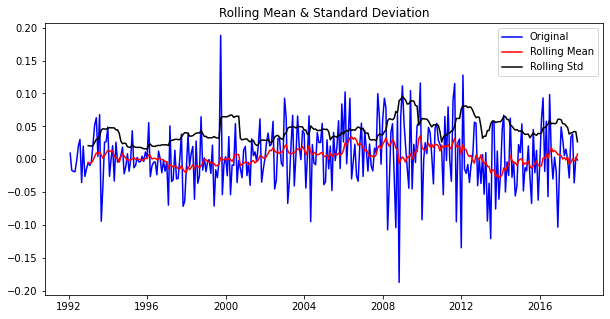

In [56]:
rolling_means(diff_data)

## Question-7: Previously we have created a functions for perfroming adf_test. Use the same function and check the adf_test results for `diff_data`

In [57]:
adf_test(diff_data)

Results of Dickey Fuller Test:
Test Statistic                 -20.032200
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    310.000000
Critical Value (1%)             -3.451622
Critical Value (5%)             -2.870909
Critical Value (10%)            -2.571762
dtype: float64


## Question-8: Is the data stationary now? Explain the results here

Yes, the data is stationary now.If Test statistic < Critical Value and p-value < 0.05 – Reject Null Hypothesis(HO) i.e., time series does not have a unit root, meaning it is stationary. 
Here, -20.032< -3.451/-2.870/-2.571 & 0.00 < 0.05, therefore null hypothesis is rejected and series is stationary or we can say series has no unit root.
The p-value is very less than the significance level of 0.05 and hence we can reject the null hypothesis and take that the series is stationary. 

## Now, before performing time series forecasting lets plot the acf and pacf

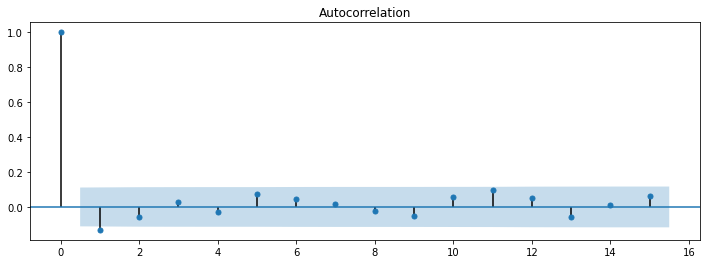

In [58]:
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(12,4))
plot_acf(diff_data, ax=plt.gca(), lags = 15)
plt.show()

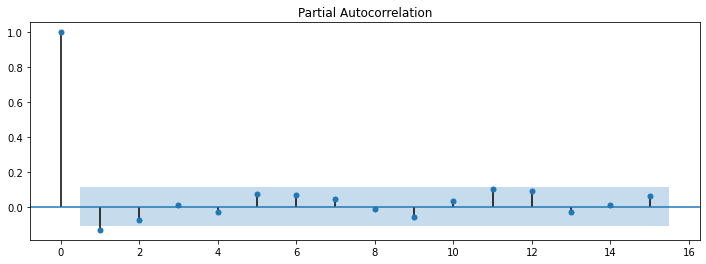

In [59]:
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize=(12,4))
plot_pacf(diff_data, ax=plt.gca(), lags = 15)
plt.show()

## Question-9: What can you infer from the above plots?

The Autocorrelation is a correlation between observations taken with a fixed interval in a time series.

The Partial-Autocorrelation measures the strength of relationship with other terms being accounted for.

By looking at both the plots and identifying the patterns they follow, we can form model conclusions.

Here, Autocorrelation follows the pattern "non-zero values at first 'q' points; zero values elsewhere" and Partial-Autocorrelation follows "Tapers to 0 in some fashion", we can infer that the conclusion model would be MA(ARIMA)

### Performing log transformation and differencing on the test dataset

In [60]:
log_test = np.log(test)
diff_test = pd.DataFrame(log_test - log_test.shift()).dropna()

Now let's build an AR Model using the differenced data

In [61]:
from statsmodels.tsa.ar_model import AR
model = AR(diff_data)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

Lag: 16
Coefficients: const        0.003506
L1.Value    -0.160056
L2.Value    -0.073148
L3.Value     0.021695
L4.Value    -0.021173
L5.Value     0.067285
L6.Value     0.061777
L7.Value     0.035910
L8.Value    -0.019759
L9.Value    -0.054927
L10.Value    0.044430
L11.Value    0.108326
L12.Value    0.084348
L13.Value   -0.022856
L14.Value    0.023745
L15.Value    0.068586
L16.Value    0.040176
dtype: float64


## Make predictions (ONLY FOR THE NEXT 12 MONTHS )

## Using the model(trained in the previous step) to predict for next 12 months.

In [62]:
predictions = model_fit.predict(start=len(diff_data), end=len(diff_data)+len(diff_test)-1, dynamic=False)
predictions.head()

for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i], diff_test.iloc[i]))
    

predicted=0.008142, expected=0.012079
predicted=0.010217, expected=0.038259
predicted=-0.002541, expected=-0.025368
predicted=0.001040, expected=0.012236
predicted=0.003064, expected=-0.012733
predicted=0.003953, expected=-0.009609
predicted=0.010678, expected=-0.036820
predicted=0.009425, expected=-0.023351
predicted=-0.000055, expected=-0.015668
predicted=-0.002392, expected=-0.008956
predicted=0.007175, expected=0.034542
predicted=0.007800, expected=-0.000691


## Plotting the AR MODEL 

Plotting AR model


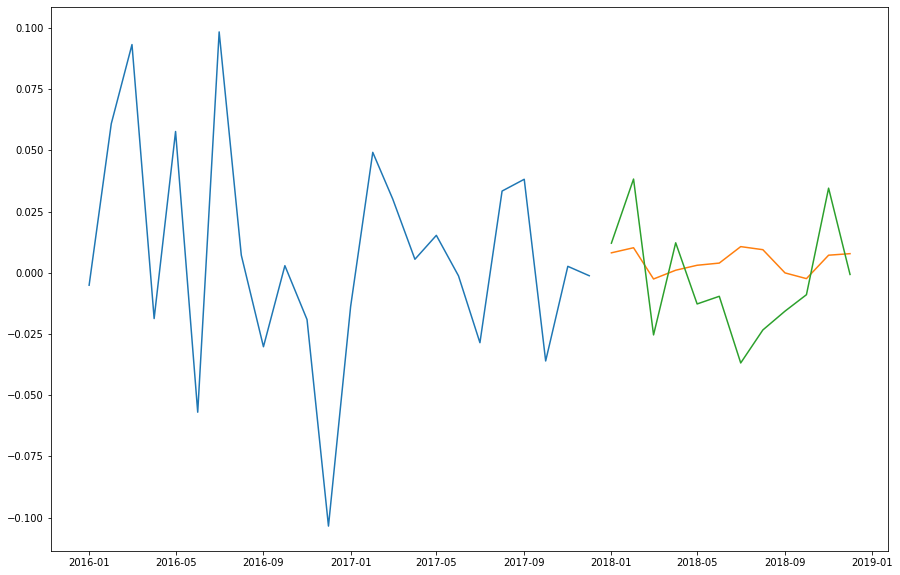

In [63]:
plt.figure(figsize = (15,10))
plt.plot(diff_data[-24:])
plt.plot(predictions)
plt.plot(diff_test)
print('Plotting AR model')

In [64]:
diff_test = diff_test['Value']

## Evaluate the accuracy of the model using metrics such as MSE and MAPE

In [65]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(predictions, diff_test)

2773.8923647686447

In [66]:
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
error = mean_squared_error(predictions, diff_test)
print('Test MSE: %.3f' % error)

Test MSE: 0.001


## Now let's build a MA Mode using the differenced data: Use order = (0,0,1)

In [67]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(diff_data,order=(0,0,1))
results_MA = model.fit()
print('Lag: %s' % results_MA.k_ar)
print('Coefficients: %s' % results_MA.params)

Lag: 0
Coefficients: const          0.004132
ma.L1.Value   -0.149248
dtype: float64


## Make predictions (ONLY FOR THE NEXT 12 MONTHS )

## Using the model(trained in the previous step) to predict for next 12 months.

In [68]:
predictions_ma = results_MA.predict(start=len(diff_data), end=len(diff_data)+len(diff_test)-1, dynamic=False)
predictions_ma.head()

for i in range(len(predictions_ma)):
    print('predicted=%f, expected=%f' % (predictions_ma[i], diff_test.iloc[i]))

predicted=0.005078, expected=0.012079
predicted=0.004132, expected=0.038259
predicted=0.004132, expected=-0.025368
predicted=0.004132, expected=0.012236
predicted=0.004132, expected=-0.012733
predicted=0.004132, expected=-0.009609
predicted=0.004132, expected=-0.036820
predicted=0.004132, expected=-0.023351
predicted=0.004132, expected=-0.015668
predicted=0.004132, expected=-0.008956
predicted=0.004132, expected=0.034542
predicted=0.004132, expected=-0.000691


## Plotting the MA Model

Plotting MA model


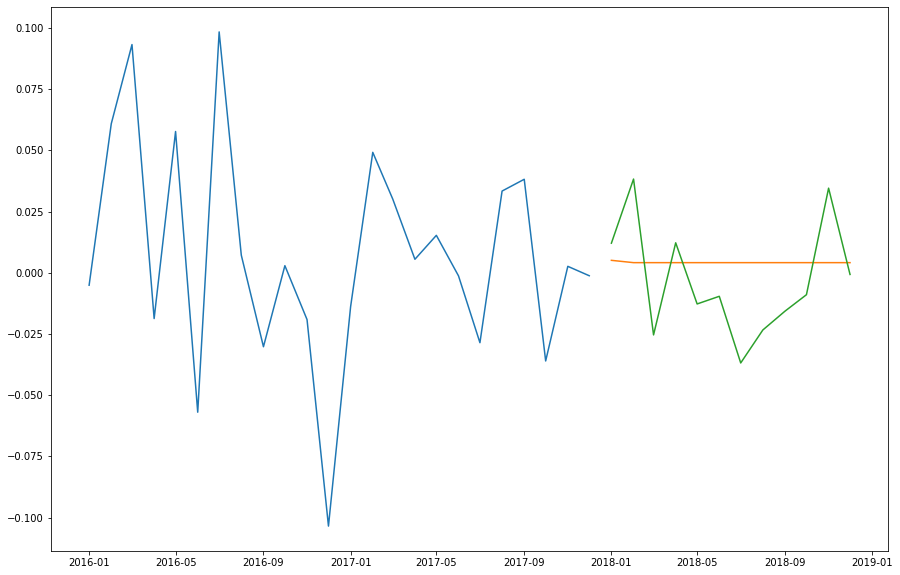

In [69]:
plt.figure(figsize = (15,10))
plt.plot(diff_data[-24:])
plt.plot(predictions_ma)
plt.plot(diff_test)
print('Plotting MA model')

## Evaluate the accuracy of the MA model using metrics such as MSE and MAPE

In [70]:
mean_absolute_percentage_error(predictions_ma, diff_test)

493.3204640771169

In [71]:
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
error = mean_squared_error(predictions_ma, diff_test)
print('Test MSE: %.3f' % error)

Test MSE: 0.001


## Using the value p as 11 and q as 2, building a ARMA model.

In [72]:
from statsmodels.tsa.arima_model import ARMA
model = ARMA(diff_data,order=(11,2))
model_arma = model.fit(transparams=False)
print('Lag: %s' % model_arma.k_ar)
print('Coefficients: %s' % model_arma.params)

Lag: 11
Coefficients: const           0.003855
ar.L1.Value     0.514710
ar.L2.Value     0.187044
ar.L3.Value     0.092763
ar.L4.Value    -0.013611
ar.L5.Value     0.078563
ar.L6.Value     0.013561
ar.L7.Value    -0.022245
ar.L8.Value    -0.056336
ar.L9.Value    -0.036638
ar.L10.Value    0.077501
ar.L11.Value    0.067173
ma.L1.Value    -0.678872
ma.L2.Value    -0.166721
dtype: float64


## Making predictions using ARMA model

In [73]:
predictions_arma = model_arma.predict(start=len(diff_data), end=len(diff_data)+len(diff_test)-1, dynamic=False)
predictions_arma.head()

for i in range(len(predictions_arma)):
    print('predicted=%f, expected=%f' % (predictions_arma[i], diff_test.iloc[i]))

predicted=0.001233, expected=0.012079
predicted=0.007336, expected=0.038259
predicted=0.004389, expected=-0.025368
predicted=0.003102, expected=0.012236
predicted=-0.001472, expected=-0.012733
predicted=0.001826, expected=-0.009609
predicted=0.008259, expected=-0.036820
predicted=0.004952, expected=-0.023351
predicted=0.002559, expected=-0.015668
predicted=0.002813, expected=-0.008956
predicted=0.002202, expected=0.034542
predicted=0.003228, expected=-0.000691


Plotting ARMA model


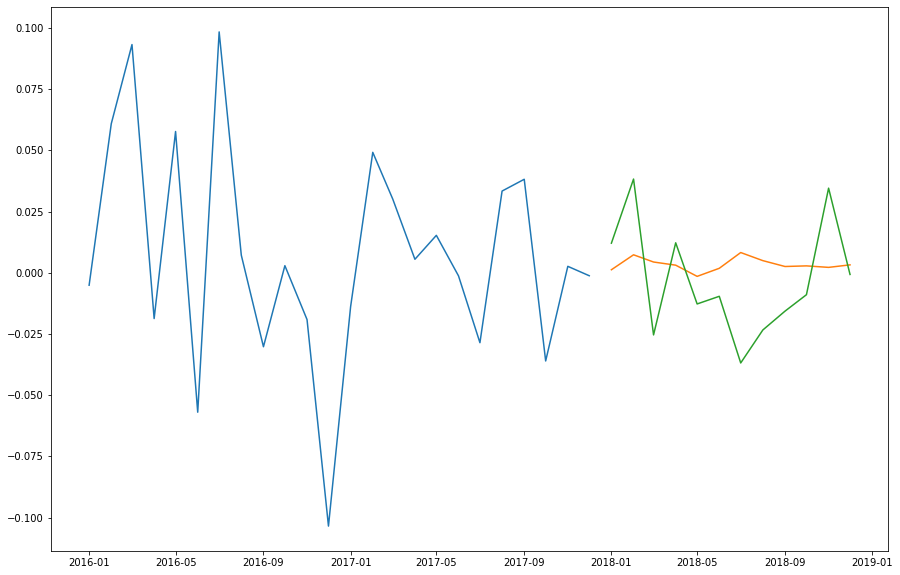

In [74]:
plt.figure(figsize = (15,10))
plt.plot(diff_data[-24:])
plt.plot(predictions_arma)
plt.plot(diff_test)
print('Plotting ARMA model')

## Evaluate the accuracy of the ARMA model using metrics such as MSE and MAPE`

In [75]:
mean_absolute_percentage_error(predictions_arma, diff_test)

625.2956847512557

In [76]:
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
error = mean_squared_error(predictions_arma, diff_test)
print('Test MSE: %.3f' % error)

Test MSE: 0.001


## Question-10: Compare AR,MA and ARMA models using the evaluation metrics and decide the best performing model.

The Evaluation metrics for AR, MA and ARMA models are MAPE(Mean Absolute Percentage Error) and MSE(Mean Squared Error).


AS observed, the MSE values for all three models are similar, but the MAPE values differ considerably.


Using MAPE as the final evaluation criteria, we can deduce that MA model gives the least error and is best suited for this time series dataset.